In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import time
import math
from sklearn import metrics
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



In [7]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
print(train_data.shape)
print(test_data.shape)

(891, 12)
(418, 11)


In [8]:
train_data.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

In [9]:
full_data = [train_data, test_data]

# Feature that tells whether a passenger had a cabin on the Titanic
train_data['Has_Cabin'] = train_data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_data['Has_Cabin'] = test_data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train_data['Fare'].median())
train_data['CategoricalFare'] = pd.qcut(train_data['Fare'], 4,duplicates='drop')
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train_data['CategoricalAge'] = pd.cut(train_data['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    # Mapping titles
    title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                      

C:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train_data = train_data.drop(drop_elements, axis = 1)
train_data = train_data.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test_data  = test_data.drop(drop_elements, axis = 1)

In [11]:
train_data.head(3)

Survived  Pclass  Sex  Age  Parch  Fare  Embarked  Has_Cabin  FamilySize  \
0         0       3    1    1      0     0         0          0           2   
1         1       1    0    2      0     3         1          1           2   
2         1       3    0    1      0     1         0          0           1   

   IsAlone  Title  
0        0      0  
1        0      2  
2        1      1

In [12]:
colormap = plt.cm.rainbow
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### SIMPLE LOGISTIC REGRESSION:

In [13]:
train_data = train_data.as_matrix()
test_data = test_data.as_matrix()
X_train = train_data[100:,1:]
y_train = train_data[100:,:1]
y_train = np.reshape(y_train,-1)
X_val = train_data[:100,1:]
y_val = train_data[:100,:1]
y_val = np.reshape(y_val,-1)
X_test = test_data
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)

Train data shape:  (791, 10)
Train labels shape:  (791,)
Validation data shape:  (100, 10)
Validation labels shape:  (100,)
Test data shape:  (418, 10)


In [14]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [cost_op,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in np.arange(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in np.arange(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {x: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"
              .format(total_loss,total_correct,e+1))
        if plot_losses and (e == epochs-1):
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [15]:
numFeatures = X_train.shape[1]
numLabels = 2

### CREATING PLACEHOLDERS AND INITIALIZATIONS:

In [16]:
# clear old variables
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, numFeatures])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
Lambda = 0.001 #Regularization Parameter
learningRate = tf.train.exponential_decay(learning_rate=1e-2,
                                          global_step= 1,
                                          decay_steps=X_train.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

### LOGISTIC REGRESSION MODEL:

fully_connected_layer = x*weights + bias

activation_layer = sigmoid(fully_connected_layer)

Loss = cross_entropy(activation_layer)+Lambda*L2_los

In [17]:
# Logistic Regression
def Titanicmodel(x,y,is_training):   
    weights=tf.get_variable("weights",shape=[numFeatures,numLabels])
    bias=tf.get_variable("bias",shape=[numLabels])
    y_out = tf.matmul(x,weights)+bias
    return(y_out,weights)
y_out,weights = Titanicmodel(x,y,is_training)

In [18]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.one_hot(y,2),logits=y_out))
regularizer = tf.nn.l2_loss(weights)
cost_op = tf.reduce_mean(loss + Lambda * regularizer)
optimizer = tf.train.GradientDescentOptimizer(learningRate)
train_step = optimizer.minimize(cost_op)

In [19]:
#Prediction
prediction = tf.argmax(y_out,1)

In [20]:
#Lets strat a session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### TRAINING & VALIDATION

<b>PARAMETERS</b>
<p>
session, predict, loss_val, Xd, yd,epochs, batch_size, print_every,training, plot_losses

 Here I am using epochs = 100, batch_size = 100, print_every = 100.

 Tune this accordingly to get best results.

In [21]:
print('Training')
run_model(sess,y_out,cost_op,X_train,y_train,100,100,100,train_step,True)
print('Validation')
run_model(sess,y_out,cost_op,X_val,y_val,1,100)

Training
Iteration 0: with minibatch training loss = 0.989 and accuracy of 0.53
Epoch 1, Overall loss = 1.17 and accuracy of 0.368
Epoch 2, Overall loss = 1.13 and accuracy of 0.37
Epoch 3, Overall loss = 1.1 and accuracy of 0.389
Epoch 4, Overall loss = 1.06 and accuracy of 0.422
Epoch 5, Overall loss = 1.03 and accuracy of 0.422
Epoch 6, Overall loss = 1 and accuracy of 0.426
Epoch 7, Overall loss = 0.969 and accuracy of 0.437
Epoch 8, Overall loss = 0.94 and accuracy of 0.441
Epoch 9, Overall loss = 0.914 and accuracy of 0.444
Epoch 10, Overall loss = 0.891 and accuracy of 0.444
Epoch 11, Overall loss = 0.873 and accuracy of 0.445
Epoch 12, Overall loss = 0.857 and accuracy of 0.448
Iteration 100: with minibatch training loss = 0.896 and accuracy of 0.44
Epoch 13, Overall loss = 0.843 and accuracy of 0.45
Epoch 14, Overall loss = 0.829 and accuracy of 0.455
Epoch 15, Overall loss = 0.817 and accuracy of 0.458
Epoch 16, Overall loss = 0.805 and accuracy of 0.458
Epoch 17, Overall los

Validation
Epoch 1, Overall loss = 0.57 and accuracy of 0.71


(0.5696372985839844, 0.71)

### RECEIVER OPERATING CHARACTERISTIC(ROC) CURVE: 

ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

This can be used to analyse if the classifier is skewed or not. (i.e) To make sure that the classifier doesn't always predict the same output

In [22]:
predicted_vallabels = np.zeros(X_val.shape[0])
for i in np.arange(0,X_val.shape[0]/50,dtype=np.int64):
    start = i*50
    end = (i+1)*50
    predicted_vallabels[start:end] = sess.run(prediction,feed_dict={x: X_val[start:end,:],y: predicted_vallabels[start:end],is_training: False})
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = metrics.roc_curve(y_val, predicted_vallabels)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_Curve')
plt.legend(loc="lower right")
plt.show()

### PREDICTION: 

Predict the test_labels using the trained model and weights

In [23]:
predicted_labels = np.zeros(X_test.shape[0])
for i in np.arange(0,X_test.shape[0]/50,dtype=np.int64):
    start = i*50
    end = (i+1)*50
    predicted_labels[start:end] = sess.run(prediction,feed_dict={x: X_test[start:end,:],y: predicted_labels[start:end],is_training: False})

In [24]:
print('predicted_labels:',predicted_labels[5])

predicted_labels: 0.0


In [28]:
testID=pd.read_csv('../input/gender_submission.csv')
print(testID.shape)
PassengerId = testID['PassengerId']

(418, 2)


### MAKE SUBMISSION FILE:

In [29]:
# save results
np.savetxt('submission.csv', 
           np.c_[PassengerId,predicted_labels], 
           delimiter=',', 
           header = 'PassengerId,Survived', 
           comments = '', 
           fmt='%d')

In [96]:
sess.close()

# S&P 500 RETURNS

In [1]:
def get_returns_daily_df(filename):
    """Load the data and calculate log return.  Remove the 
    first row because it will always be NaN."""
    df = pd.read_csv(filename) 
    df.set_index(df['Dates'], inplace=True)
    df.drop('Dates', axis=1, inplace=True)
    df_ret = np.log(df / df.shift())
    return df_ret.iloc[1:]

def train_test_split(df, training_pct, validation_pct):
    training_set_end_idx = int(df.shape[0] * training_pct)
    validation_set_end_idx = int(df.shape[0] * (training_pct+ validation_pct))
    m_training = df[0:training_set_end_idx].copy()
    m_validation = df[training_set_end_idx:validation_set_end_idx].copy()
    m_test = df[validation_set_end_idx:].copy()
    return m_training, m_validation, m_test

def get_sp500_anomalies(df, threshold):
    df_anomalies = df.copy()
    df_anomalies.drop('Adj Close', axis=1, inplace=True)
    df_anomalies[abs(df_anomalies) < threshold] = 0
    df_anomalies[df_anomalies != 0] = 1
    return df_anomalies

In [181]:
INPUT_FILE = r"C:\phd\rpca\input\prices\sp500_constituents_eod_prices.csv"
constituents_returns_df = get_returns_daily_df(INPUT_FILE)
constituents_returns_df = constituents_returns_df.round(7)

#### Correlation Among Stocks

In [182]:
# colormap = plt.cm.rainbow
# plt.figure(figsize=(12,12))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
# sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

#### Setup Simple Logistic Regression 

In [183]:
# train_data = train_data.as_matrix()
# test_data = test_data.as_matrix()
# X_train = train_data[100:,1:]
# y_train = train_data[100:,:1]
# y_train = np.reshape(y_train,-1)
# X_val = train_data[:100,1:]
# y_val = train_data[:100,:1]
# y_val = np.reshape(y_val,-1)
# X_test = test_data
# print('Train data shape: ', X_train.shape)
# print('Train labels shape: ', y_train.shape)
# print('Validation data shape: ', X_val.shape)
# print('Validation labels shape: ', y_val.shape)
# print('Test data shape: ', X_test.shape)

#### Load Data 

In [184]:
# split_pct = 0.66
# validation_pct = 0.17
# training_set_end_idx = int(df.shape[0] * split_pct)
# validation_set_end_idx = int(df.shape[0] * (split_pct+ validation_pct))
# m_training = df[0:training_set_end_idx].copy()
# m_validation = df[training_set_end_idx:validation_set_end_idx].copy()
# m_test = df[validation_set_end_idx:].copy()

# print('Train data shape: ', m_training.shape)
# # print('Train labels shape: ', y_train.shape)
# print('Validation data shape: ', m_validation.shape)
# # print('Validation labels shape: ', y_val.shape)
# print('Test data shape: ', m_test.shape)

#### Load S&P 500 Index Levels 

Decide what is an anomaly, by labeling days with absolute return above a threshold as anomalies

In [185]:
sp500_df = pd.read_csv(r'C:\phd\input\rpca\GSPC.csv')
sp500_df = sp500_df.set_index('Date')
sp500_df.index = pd.to_datetime(sp500_df.index)
df_ = sp500_df[['Adj Close']].copy()
df_returns = np.log(df_/df_.shift())
sp500_returns_df = df_returns.iloc[1:].copy()
sp500_returns_df.columns = ['Return']
sp500_returns_df['Adj Close'] = df_.loc[sp500_returns_df.index]['Adj Close']

Split the data set and decide what is an anomaly

In [186]:
split_pct = 0.66
validation_pct = 0.17
X_training_df, X_validation_df, X_test_df = train_test_split(constituents_returns_df, split_pct, validation_pct)
sp500_training_df, sp500_validation_df, sp500_test_df = train_test_split(sp500_returns_df, split_pct, validation_pct)

In [187]:
threshold = 0.02
Y_training_anomalies = get_sp500_anomalies(sp500_training_df, threshold)
Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df, threshold)
Y_test_anomalies = get_sp500_anomalies(sp500_test_df, threshold)

In [188]:
# ----------------------------------------------
# Remove NaN
# This happens because index constituents change
# ----------------------------------------------
X_training_df.dropna(axis=1, how='any', inplace=True)
X_validation_df.dropna(axis=1, how='any', inplace=True)
X_test_df.dropna(axis=1, how='any', inplace=True)

# common tickers across all years
list_of_tickers = list(set(X_training_df.columns) & set(X_validation_df.columns) & set(X_test_df.columns))
list_of_tickers.sort()

# Now use the data
X_train = X_training_df[list_of_tickers].as_matrix()
y_train = Y_training_anomalies.as_matrix()
y_train = np.reshape(y_train,-1)
X_val = X_validation_df[list_of_tickers].as_matrix()
y_val = Y_validation_anomalies.as_matrix()
y_val = np.reshape(y_val,-1)
X_test = X_test_df[list_of_tickers].as_matrix()
y_test = Y_test_anomalies.as_matrix()
y_test = np.reshape(y_test,-1)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (1954, 476)
Train labels shape:  (1954,)
Validation data shape:  (503, 476)
Validation labels shape:  (503,)
Test data shape:  (504, 476)
Test labels shape:  (504,)


##### Number of Features and Number of Labels

In [189]:
numFeatures = X_train.shape[1]
numLabels = 2

##### Creating Placeholders and Initializations

In [190]:
# clear old variables
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, numFeatures])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
Lambda = 0.001 #Regularization Parameter
learningRate = tf.train.exponential_decay(learning_rate=1e-2,
                                          global_step= 1,
                                          decay_steps=X_train.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

##### Make the Logistic Regression Model

In [191]:
# Logistic Regression Model
def SP500AnomalyDetectorModel(x,y,is_training):   
    weights=tf.get_variable("weights",shape=[numFeatures,numLabels])
    bias=tf.get_variable("bias",shape=[numLabels])
    y_out = tf.matmul(x,weights)+bias
    return(y_out,weights)

y_out,weights = SP500AnomalyDetectorModel(x,y,is_training)

In [192]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.one_hot(y,2),logits=y_out))
regularizer = tf.nn.l2_loss(weights)
cost_op = tf.reduce_mean(loss + Lambda * regularizer)
optimizer = tf.train.GradientDescentOptimizer(learningRate)
train_step = optimizer.minimize(cost_op)

In [193]:
#Prediction
prediction = tf.argmax(y_out,1)

In [194]:
#Lets strat a session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

##### Training and Validation

<b>PARAMETERS</b>
<p>
session, predict, loss_val, Xd, yd,epochs, batch_size, print_every,training, plot_losses

 Here I am using epochs = 100, batch_size = 100, print_every = 100.

 Tune this accordingly to get best results.

Training
Iteration 0: with minibatch training loss = 0.388 and accuracy of 1
Iteration 0: with minibatch training loss = 0.388 and accuracy of 1
Iteration 1: with minibatch training loss = 0.402 and accuracy of 0.98
Iteration 2: with minibatch training loss = 0.402 and accuracy of 0.98
Iteration 3: with minibatch training loss = 0.418 and accuracy of 0.96
Iteration 4: with minibatch training loss = 0.479 and accuracy of 0.88
Iteration 5: with minibatch training loss = 0.504 and accuracy of 0.85
Iteration 6: with minibatch training loss = 0.569 and accuracy of 0.77
Iteration 7: with minibatch training loss = 0.813 and accuracy of 0.46
Iteration 8: with minibatch training loss = 0.612 and accuracy of 0.71
Iteration 9: with minibatch training loss = 0.434 and accuracy of 0.94
Iteration 10: with minibatch training loss = 0.432 and accuracy of 0.94
Iteration 11: with minibatch training loss = 0.502 and accuracy of 0.85
Iteration 12: with minibatch training loss = 0.402 and accuracy of 0.98


Iteration 159: with minibatch training loss = 0.34 and accuracy of 1
Epoch 8, Overall loss = 0.443 and accuracy of 0.891
Iteration 160: with minibatch training loss = 0.339 and accuracy of 1
Iteration 161: with minibatch training loss = 0.356 and accuracy of 0.98
Iteration 162: with minibatch training loss = 0.356 and accuracy of 0.98
Iteration 163: with minibatch training loss = 0.375 and accuracy of 0.96
Iteration 164: with minibatch training loss = 0.449 and accuracy of 0.88
Iteration 165: with minibatch training loss = 0.478 and accuracy of 0.85
Iteration 166: with minibatch training loss = 0.556 and accuracy of 0.77
Iteration 167: with minibatch training loss = 0.847 and accuracy of 0.46
Iteration 168: with minibatch training loss = 0.609 and accuracy of 0.71
Iteration 169: with minibatch training loss = 0.395 and accuracy of 0.94
Iteration 170: with minibatch training loss = 0.393 and accuracy of 0.94
Iteration 171: with minibatch training loss = 0.478 and accuracy of 0.85
Iterat

Iteration 334: with minibatch training loss = 0.641 and accuracy of 0.68
Iteration 335: with minibatch training loss = 0.311 and accuracy of 0.99
Iteration 336: with minibatch training loss = 0.352 and accuracy of 0.95
Iteration 337: with minibatch training loss = 0.32 and accuracy of 0.98
Iteration 338: with minibatch training loss = 0.319 and accuracy of 0.98
Iteration 339: with minibatch training loss = 0.298 and accuracy of 1
Epoch 17, Overall loss = 0.417 and accuracy of 0.891
Iteration 340: with minibatch training loss = 0.298 and accuracy of 1
Iteration 341: with minibatch training loss = 0.318 and accuracy of 0.98
Iteration 342: with minibatch training loss = 0.318 and accuracy of 0.98
Iteration 343: with minibatch training loss = 0.34 and accuracy of 0.96
Iteration 344: with minibatch training loss = 0.426 and accuracy of 0.88
Iteration 345: with minibatch training loss = 0.459 and accuracy of 0.85
Iteration 346: with minibatch training loss = 0.548 and accuracy of 0.77
Iterat

Iteration 533: with minibatch training loss = 0.277 and accuracy of 0.99
Iteration 534: with minibatch training loss = 0.65 and accuracy of 0.68
Iteration 535: with minibatch training loss = 0.278 and accuracy of 0.99
Iteration 536: with minibatch training loss = 0.325 and accuracy of 0.95
Iteration 537: with minibatch training loss = 0.289 and accuracy of 0.98
Iteration 538: with minibatch training loss = 0.288 and accuracy of 0.98
Iteration 539: with minibatch training loss = 0.264 and accuracy of 1
Epoch 27, Overall loss = 0.397 and accuracy of 0.891
Iteration 540: with minibatch training loss = 0.264 and accuracy of 1
Iteration 541: with minibatch training loss = 0.287 and accuracy of 0.98
Iteration 542: with minibatch training loss = 0.287 and accuracy of 0.98
Iteration 543: with minibatch training loss = 0.311 and accuracy of 0.96
Iteration 544: with minibatch training loss = 0.408 and accuracy of 0.88
Iteration 545: with minibatch training loss = 0.446 and accuracy of 0.85
Itera

Iteration 712: with minibatch training loss = 0.269 and accuracy of 0.98
Iteration 713: with minibatch training loss = 0.254 and accuracy of 0.99
Iteration 714: with minibatch training loss = 0.659 and accuracy of 0.68
Iteration 715: with minibatch training loss = 0.255 and accuracy of 0.99
Iteration 716: with minibatch training loss = 0.307 and accuracy of 0.95
Iteration 717: with minibatch training loss = 0.267 and accuracy of 0.98
Iteration 718: with minibatch training loss = 0.266 and accuracy of 0.98
Iteration 719: with minibatch training loss = 0.241 and accuracy of 1
Epoch 36, Overall loss = 0.385 and accuracy of 0.891
Iteration 720: with minibatch training loss = 0.241 and accuracy of 1
Iteration 721: with minibatch training loss = 0.266 and accuracy of 0.98
Iteration 722: with minibatch training loss = 0.266 and accuracy of 0.98
Iteration 723: with minibatch training loss = 0.292 and accuracy of 0.96
Iteration 724: with minibatch training loss = 0.397 and accuracy of 0.88
Iter

Iteration 896: with minibatch training loss = 0.293 and accuracy of 0.95
Iteration 897: with minibatch training loss = 0.251 and accuracy of 0.98
Iteration 898: with minibatch training loss = 0.249 and accuracy of 0.98
Iteration 899: with minibatch training loss = 0.223 and accuracy of 1
Epoch 45, Overall loss = 0.376 and accuracy of 0.891
Iteration 900: with minibatch training loss = 0.222 and accuracy of 1
Iteration 900: with minibatch training loss = 0.222 and accuracy of 1
Iteration 901: with minibatch training loss = 0.25 and accuracy of 0.98
Iteration 902: with minibatch training loss = 0.249 and accuracy of 0.98
Iteration 903: with minibatch training loss = 0.277 and accuracy of 0.96
Iteration 904: with minibatch training loss = 0.389 and accuracy of 0.88
Iteration 905: with minibatch training loss = 0.433 and accuracy of 0.85
Iteration 906: with minibatch training loss = 0.546 and accuracy of 0.77
Iteration 907: with minibatch training loss = 0.981 and accuracy of 0.46
Iteratio

Iteration 1090: with minibatch training loss = 0.294 and accuracy of 0.94
Iteration 1091: with minibatch training loss = 0.431 and accuracy of 0.85
Iteration 1092: with minibatch training loss = 0.237 and accuracy of 0.98
Iteration 1093: with minibatch training loss = 0.221 and accuracy of 0.99
Iteration 1094: with minibatch training loss = 0.679 and accuracy of 0.68
Iteration 1095: with minibatch training loss = 0.222 and accuracy of 0.99
Iteration 1096: with minibatch training loss = 0.281 and accuracy of 0.95
Iteration 1097: with minibatch training loss = 0.236 and accuracy of 0.98
Iteration 1098: with minibatch training loss = 0.235 and accuracy of 0.98
Iteration 1099: with minibatch training loss = 0.206 and accuracy of 1
Epoch 55, Overall loss = 0.368 and accuracy of 0.891
Iteration 1100: with minibatch training loss = 0.206 and accuracy of 1
Iteration 1100: with minibatch training loss = 0.206 and accuracy of 1
Iteration 1101: with minibatch training loss = 0.235 and accuracy of

Iteration 1268: with minibatch training loss = 0.646 and accuracy of 0.71
Iteration 1269: with minibatch training loss = 0.287 and accuracy of 0.94
Iteration 1270: with minibatch training loss = 0.286 and accuracy of 0.94
Iteration 1271: with minibatch training loss = 0.429 and accuracy of 0.85
Iteration 1272: with minibatch training loss = 0.226 and accuracy of 0.98
Iteration 1273: with minibatch training loss = 0.21 and accuracy of 0.99
Iteration 1274: with minibatch training loss = 0.687 and accuracy of 0.68
Iteration 1275: with minibatch training loss = 0.211 and accuracy of 0.99
Iteration 1276: with minibatch training loss = 0.272 and accuracy of 0.95
Iteration 1277: with minibatch training loss = 0.225 and accuracy of 0.98
Iteration 1278: with minibatch training loss = 0.224 and accuracy of 0.98
Iteration 1279: with minibatch training loss = 0.194 and accuracy of 1
Epoch 64, Overall loss = 0.363 and accuracy of 0.891
Iteration 1280: with minibatch training loss = 0.194 and accura

Iteration 1465: with minibatch training loss = 0.425 and accuracy of 0.85
Iteration 1466: with minibatch training loss = 0.553 and accuracy of 0.77
Iteration 1467: with minibatch training loss = 1.05 and accuracy of 0.46
Iteration 1468: with minibatch training loss = 0.654 and accuracy of 0.71
Iteration 1469: with minibatch training loss = 0.28 and accuracy of 0.94
Iteration 1470: with minibatch training loss = 0.278 and accuracy of 0.94
Iteration 1471: with minibatch training loss = 0.427 and accuracy of 0.85
Iteration 1472: with minibatch training loss = 0.217 and accuracy of 0.98
Iteration 1473: with minibatch training loss = 0.199 and accuracy of 0.99
Iteration 1474: with minibatch training loss = 0.696 and accuracy of 0.68
Iteration 1475: with minibatch training loss = 0.2 and accuracy of 0.99
Iteration 1476: with minibatch training loss = 0.264 and accuracy of 0.95
Iteration 1477: with minibatch training loss = 0.215 and accuracy of 0.98
Iteration 1478: with minibatch training lo

Iteration 1660: with minibatch training loss = 0.175 and accuracy of 1
Iteration 1661: with minibatch training loss = 0.208 and accuracy of 0.98
Iteration 1662: with minibatch training loss = 0.206 and accuracy of 0.98
Iteration 1663: with minibatch training loss = 0.24 and accuracy of 0.96
Iteration 1664: with minibatch training loss = 0.373 and accuracy of 0.88
Iteration 1665: with minibatch training loss = 0.424 and accuracy of 0.85
Iteration 1666: with minibatch training loss = 0.556 and accuracy of 0.77
Iteration 1667: with minibatch training loss = 1.07 and accuracy of 0.46
Iteration 1668: with minibatch training loss = 0.662 and accuracy of 0.71
Iteration 1669: with minibatch training loss = 0.274 and accuracy of 0.94
Iteration 1670: with minibatch training loss = 0.272 and accuracy of 0.94
Iteration 1671: with minibatch training loss = 0.427 and accuracy of 0.85
Iteration 1672: with minibatch training loss = 0.208 and accuracy of 0.98
Iteration 1673: with minibatch training los

Iteration 1835: with minibatch training loss = 0.186 and accuracy of 0.99
Iteration 1836: with minibatch training loss = 0.254 and accuracy of 0.95
Iteration 1837: with minibatch training loss = 0.202 and accuracy of 0.98
Iteration 1838: with minibatch training loss = 0.2 and accuracy of 0.98
Iteration 1839: with minibatch training loss = 0.168 and accuracy of 1
Epoch 92, Overall loss = 0.354 and accuracy of 0.891
Iteration 1840: with minibatch training loss = 0.168 and accuracy of 1
Iteration 1841: with minibatch training loss = 0.202 and accuracy of 0.98
Iteration 1842: with minibatch training loss = 0.2 and accuracy of 0.98
Iteration 1843: with minibatch training loss = 0.235 and accuracy of 0.96
Iteration 1844: with minibatch training loss = 0.372 and accuracy of 0.88
Iteration 1845: with minibatch training loss = 0.424 and accuracy of 0.85
Iteration 1846: with minibatch training loss = 0.559 and accuracy of 0.77
Iteration 1847: with minibatch training loss = 1.09 and accuracy of 0

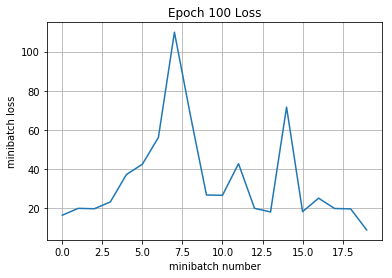

Validation
Iteration 0: with minibatch training loss = 0.214 and accuracy of 0.97
Iteration 1: with minibatch training loss = 0.18 and accuracy of 0.99
Iteration 2: with minibatch training loss = 0.197 and accuracy of 0.98
Iteration 3: with minibatch training loss = 0.198 and accuracy of 0.98
Iteration 4: with minibatch training loss = 0.319 and accuracy of 0.91
Iteration 5: with minibatch training loss = 0.157 and accuracy of 1
Epoch 1, Overall loss = 0.221 and accuracy of 0.966


(0.22130522674049583, 0.9662027833001988)

In [195]:
print('Training')
run_nn_model(sess,y_out,cost_op,X_train,y_train,100,100,100,train_step,True)
print('Validation')
run_nn_model(sess,y_out,cost_op,X_val,y_val,1,100)

In [118]:
def run_nn_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [cost_op,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in np.arange(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in np.arange(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {x: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
#             print("Epoch {3}, start_idx = {0:d} and end_idx = {1:d} and actual_batch_size = {2:d}"
#                   .format(start_idx,(start_idx+batch_size),actual_batch_size,e+1))
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"
              .format(total_loss,total_correct,e+1))
        if plot_losses and (e == epochs-1):
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [163]:
# np.savetxt(r"C:\phd\rpca\debug\X_train.csv", X_train, delimiter=",")
# np.any(np.isnan(X_training_df))

# # np.any(np.isnan(X_train))
# X_training_df.shape

# X_training_df.dropna(axis=1, how='any', inplace=True)

# list(map(tuple, np.where(np.isnan(X_train))))

##### Receiver Operating Characteristic (ROC) Curve: 

ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

This can be used to analyse if the classifier is skewed or not. (i.e) To make sure that the classifier doesn't always predict the same output

In [196]:
predicted_vallabels = np.zeros(X_val.shape[0])
for i in np.arange(0,X_val.shape[0]/50,dtype=np.int64):
    start = i*50
    end = (i+1)*50
    predicted_vallabels[start:end] = sess.run(prediction,
                                              feed_dict={x: X_val[start:end,:],
                                                         y: predicted_vallabels[start:end],
                                                         is_training: False})

In [197]:
sum(predicted_vallabels)

0.0

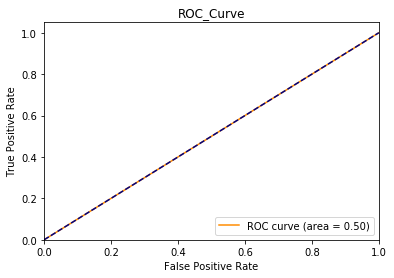

In [164]:
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = metrics.roc_curve(y_val, predicted_vallabels)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_Curve')
plt.legend(loc="lower right")
plt.show()

In [168]:
sess.close()

### Another example

<a url="https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/2_BasicModels/logistic_regression.ipynb">Tensorflow Logistic Regression</a>

In [169]:
# Parameters
learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1

# tf Graph Input
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

# Set model weights
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# Construct model
pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

# Minimize error using cross entropy
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [171]:
# Start training
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                          y: batch_ys})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch: {0:d}, cost={1:.9f}".format((epoch+1), avg_cost))

    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy for 3000 examples
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy: {0:.6f}".format(accuracy.eval({x: mnist.test.images[:3000], y: mnist.test.labels[:3000]})))

Epoch: 1, cost=1.184094957
Epoch: 2, cost=0.665269917
Epoch: 3, cost=0.552798208
Epoch: 4, cost=0.498694055
Epoch: 5, cost=0.465520567
Epoch: 6, cost=0.442518168
Epoch: 7, cost=0.425499998
Epoch: 8, cost=0.412170338
Epoch: 9, cost=0.401401060
Epoch: 10, cost=0.392339351
Epoch: 11, cost=0.384743833
Epoch: 12, cost=0.378146303
Epoch: 13, cost=0.372410938
Epoch: 14, cost=0.367258057
Epoch: 15, cost=0.362672880
Epoch: 16, cost=0.358601309
Epoch: 17, cost=0.354864072
Epoch: 18, cost=0.351483166
Epoch: 19, cost=0.348337372
Epoch: 20, cost=0.345437313
Epoch: 21, cost=0.342755387
Epoch: 22, cost=0.340225517
Epoch: 23, cost=0.337920697
Epoch: 24, cost=0.335751015
Epoch: 25, cost=0.333692506
Optimization Finished!
Accuracy: 0.889667


In [176]:
predicted_vallabels[start:end] = sess.run(prediction,feed_dict={x: X_val[start:end,:],y: predicted_vallabels[start:end],is_training: False})
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = metrics.roc_curve(y_val, predicted_vallabels)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_Curve')
plt.legend(loc="lower right")
plt.show()

In [177]:
ximages.shape

(3000, 784)

In [178]:
accuracy.

tensorflow.python.framework.ops.Tensor

In [179]:
# sess.run(W) * mnist.test.images[:3000] + sess.run(b)

RuntimeError: Attempted to use a closed Session.

###  Logistic Regression Model Fitting - Cross Validation

In [202]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# from sklearn import metrics
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)

# from sklearn import model_selection
# from sklearn.model_selection import cross_val_score
# kfold = model_selection.KFold(n_splits=10, random_state=7)
# modelCV = LogisticRegression()
# scoring = 'accuracy'
# results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
# print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

In [205]:
searchCV = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), 
                                penalty='l2',
                                scoring='roc_auc',
                                random_state=777,
                                max_iter=10000,
                                fit_intercept=True,
                                solver='newton-cg',
                                tol=10)
searchCV.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0],
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=10000, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=777, refit=True,
           scoring='roc_auc', solver='newton-cg', tol=10, verbose=0)

In [207]:
y_train_pred = searchCV.predict(X_train)

In [208]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(searchCV.score(X_train, y_train)))

Accuracy of logistic regression classifier on test set: 0.89


In [210]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(searchCV.score(X_val, y_val)))

Accuracy of logistic regression classifier on test set: 0.97


#### Confusion Matrix

In [211]:
from sklearn.metrics import confusion_matrix
y_train_pred = searchCV.predict(X_train)
y_val_pred = searchCV.predict(X_val)
y_test_pred = searchCV.predict(X_test)

training_confusion_matrix = confusion_matrix(y_train, y_train_pred)
validation_confusion_matrix = confusion_matrix(y_val, y_val_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

print("Training Confusion Matrix")
print(training_confusion_matrix)

print("Validation Confusion Matrix")
print(validation_confusion_matrix)

print("Test Confusion Matrix")
print(test_confusion_matrix)

Training Confusion Matrix
[[1741    0]
 [ 213    0]]
Validation Confusion Matrix
[[486   0]
 [ 17   0]]
Test Confusion Matrix
[[494   0]
 [ 10   0]]


#### Compute precision, recall, F-measure and support

In [212]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99       494
        1.0       0.00      0.00      0.00        10

avg / total       0.96      0.98      0.97       504



C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### ROC Curves

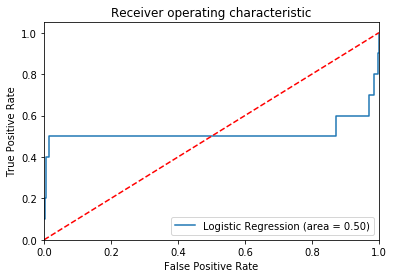

In [213]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, searchCV.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, searchCV.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# The Danger of Imbalanced Classes

In [234]:
Y_training_anomalies['Return'].value_counts()

0.0    1741
1.0     213
Name: Return, dtype: int64

In [235]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [236]:
# Train model
clf_0 = LogisticRegression().fit(X_train, y_train)
 
# Predict on training set
pred_y_train = clf_0.predict(X_train)

In [237]:
# How's the accuracy?
print( accuracy_score(y_train, pred_y_train) )

0.8930399181166837


In [238]:
print( np.unique( pred_y_train ) )

[0. 1.]


In [251]:
pred_y_test = clf_0.predict(X_test)
print( accuracy_score(y_test, pred_y_test))

0.9801587301587301


In [252]:
prob_y_test = clf_0.predict_proba(X_test)
prob_y_test = [p[1] for p in prob_y_test]
print( roc_auc_score(y_test, prob_y_test) )

0.6508097165991903


# 1. Up-sample Minority Class

In [247]:
X_training_df['Return'] = Y_training_anomalies.Return

In [248]:
# Separate majority and minority classes
df_majority = X_training_df[X_training_df.Return == 0]
df_minority = X_training_df[X_training_df.Return == 1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# # Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# # Display new class counts
df_upsampled.Return.value_counts()

1.0    1741
0.0    1741
Name: Return, dtype: int64

In [249]:
y = df_upsampled.Return
X = df_upsampled.drop('Return', axis=1)
 
# Train model
clf_1 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_1 = clf_1.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_1 ) )
 
# How's our accuracy?
print( accuracy_score(y, pred_y_1) )

[0. 1.]
0.7823090178058587


# 2. Down-sample Majority Class

In [253]:
# Separate majority and minority classes
df_majority = X_training_df[X_training_df.Return == 0]
df_minority = X_training_df[X_training_df.Return == 1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Return.value_counts()

1.0    213
0.0    213
Name: Return, dtype: int64

In [254]:
# Separate input features (X) and target variable (y)
y = df_downsampled.Return
X = df_downsampled.drop('Return', axis=1)
 
# Train model
clf_2 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_2 = clf_2.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2 ) )
 
# How's our accuracy?
print( accuracy_score(y, pred_y_2) )

[0. 1.]
0.7112676056338029


In [256]:
# pred_y_test = clf_2.predict(X_test)
# print( accuracy_score(y_test, pred_y_test))
# prob_y_test = clf_2.predict_proba(X_test)
# prob_y_test = [p[1] for p in prob_y_test]
# print( roc_auc_score(y_test, prob_y_test) )

# 3. Change Your Performance Metric

In [258]:
from sklearn.metrics import roc_auc_score

In [259]:
# Predict class probabilities
prob_y_2 = clf_2.predict_proba(X)
 
# Keep only the positive class
prob_y_2 = [p[1] for p in prob_y_2]
 
prob_y_2[:5] # Example

[0.5265512414145754,
 0.5008150640258135,
 0.467195939807049,
 0.5037415291879974,
 0.44301067740381]

In [260]:
print( roc_auc_score(y, prob_y_2) )

0.7478674866097996


In [262]:
prob_y_0 = clf_0.predict_proba(X_train)
prob_y_0 = [p[1] for p in prob_y_0]
print( roc_auc_score(y_train, prob_y_0) )

0.6511691246464042


# 4. Penalize Algorithms (Cost-Sensitive Training)

In [225]:
from sklearn.svm import SVC

In [226]:
# Train model
clf_3 = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)

In [227]:
clf_3.fit(X_train, y_train)
 
# Predict on training set
pred_y_train = clf_3.predict(X_train)

In [228]:
# Is our model still predicting just one class?
print( np.unique( pred_y_train ) )

[0. 1.]


In [229]:
# How's our accuracy?
print( accuracy_score(y_train, pred_y_train) )

0.8648925281473899


In [230]:
# What about AUROC?
prob_y_train = clf_3.predict_proba(X_train)
prob_y_train = [p[1] for p in prob_y_train]
print( roc_auc_score(y_train, prob_y_train) )

0.19028511486302463


In [231]:
pred_y_test = clf_3.predict(X_test)
print( np.unique( pred_y_test ))
print( accuracy_score(y_test, pred_y_test))
prob_y_test = clf_3.predict_proba(X_test)
prob_y_test = [p[1] for p in prob_y_test]
print( roc_auc_score(y_test, prob_y_test) )

[0. 1.]
0.8630952380952381
0.32246963562753034


# 5. Use Tree-Based Algorithms 

In [214]:
from sklearn.ensemble import RandomForestClassifier

In [215]:
# Train model
clf_4 = RandomForestClassifier()
clf_4.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [216]:
# Predict on training set
pred_y_4 = clf_4.predict(X_train)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_4 ))

[0. 1.]


In [218]:
from sklearn.metrics import accuracy_score

In [220]:
# How's our accuracy?
print( accuracy_score(y_train, pred_y_4) )

0.9979529170931423


In [222]:
# What about AUROC?
prob_y_4 = clf_4.predict_proba(X_train)
prob_y_4 = [p[1] for p in prob_y_4]
print( roc_auc_score(y_train, prob_y_4) )

0.9999959550525439


In [224]:
pred_y_test = clf_4.predict(X_test)
print( np.unique( pred_y_test ))
print( accuracy_score(y_test, pred_y_test))
prob_y_test = clf_4.predict_proba(X_test)
prob_y_test = [p[1] for p in prob_y_test]
print( roc_auc_score(y_test, prob_y_test) )

[0. 1.]
0.9841269841269841
0.932085020242915
